<a href="https://colab.research.google.com/github/samibahig/RecoverProject/blob/main/Copy_of_PLS_DA_Metabolomique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import sklearn
import os
plt.style.use('ggplot')
#print('\nMETADATA :')
data_path = ''
metadata_filename = data_path + '/content/metadata.csv'
meta_df = pd.read_csv(metadata_filename)
#print(meta_df.columns)
meta_df.columns = ['#', 'plate', '-', 'symptoms'] + list(meta_df)[4:]
#print(meta_df.columns)
#print('available metadata :', list(meta_df))
meta_idx = meta_df['ID'].to_list()
meta_label = meta_df['symptoms'].to_list()
#print('------------------')
#print(list(zip(meta_idx, meta_label)))
#print('------------------')
meta_id_label_dict = {str(k): 1 if v=='S' else 0 for k, v in zip(meta_idx, meta_label)}


data_path = ''
print('\nMETABOLOMICS DATA :')
metabolomics_data_filename = data_path + '/content/metabolomics.csv'
feat_df = pd.read_csv(metabolomics_data_filename, index_col=0, skiprows=[0], dtype=str, usecols=[0])
features = list(feat_df.index.values)
print('# of features : ', len(features))
print('first feature :', features[0])
print('last feature :', features[-1])
col_list = ["Group"]
column1 = pd.read_csv(metabolomics_data_filename, usecols=col_list)
print('----------')
column1 = column1['Group'].to_list()
print(column1[1:])

print('----------')
idx_df = pd.read_csv(metabolomics_data_filename, header=1, nrows=1, encoding='unicode_escape')
print(idx_df)
idx = list(idx_df)[1:]
idx = [l[17:22] for l in idx]
labels_df = pd.read_csv(metabolomics_data_filename, nrows=1)
labels = list(labels_df)[1:]
print('# of labels : ', len(labels))

cols_df = pd.read_csv(metabolomics_data_filename, header=1, nrows=1, encoding='unicode_escape')
cols_list = list(cols_df)

df3 = pd.read_csv(metabolomics_data_filename, header=1, na_values=['#DIV/0!'], usecols=cols_list[1:], encoding='unicode_escape')
df3 = df3.T
df3['idx'] = idx
df3.set_index('idx', inplace=True)
df3.columns = features
df3 = df3.dropna(axis=1)

#clean data of samples that are not in metadata :
idx = df3.index.values
y = []
for k in range(len(idx)):
    id = idx[k]
    if id in meta_id_label_dict:
        y.append(meta_id_label_dict[id])
    else:
        # we will not put this sample in the dataset
        #print('sample to remove because of unknown label:', k, id)
        y.append('to_remove')
df3['label'] = y
df3 = df3[df3.label != 'to_remove']

#create X and y matrices for ML :
y = list(df3['label'])
print(y)
del df3['label']
X = df3.to_numpy()

print('metabolomics data :')
print('# of samples : ', df3.shape[0])
print('# of features : ', df3.shape[1])
print('labels:', list(dict.fromkeys(y)))

## to concatenate the 2 proteomics dataframes and the metabolomics if you want :
##df = pd.concat([df_1_2, df3], axis=1)
##df = df.dropna(axis=0)
##print('multi-omics df :')
##print('# of samples : ', df.shape[0])
##print('# of features : ', df.shape[1])


METABOLOMICS DATA :
# of features :  965
first feature : 3.15_160.1695m/z
last feature : 0.48_535.7400n
----------
['3.15_160.1695m/z', '8.56_366.6297m/z', '6.52_828.4067n', '7.23_281.0516m/z', '8.34_429.0893m/z', '4.55_252.0298m/z', '4.56_234.0194m/z', '4.55_220.0590m/z', '5.19_386.0794m/z', '8.56_367.6297m/z', '4.55_337.0498n', '7.68_358.3671m/z', '5.07_371.2588m/z', '5.87_393.0866m/z', '8.34_485.1126m/z', '8.34_445.1197m/z', '4.04_133.0143m/z', '7.68_355.0720m/z', '8.87_519.1391m/z', '4.54_352.0727m/z', '8.34_248.0596m/z', '8.34_355.0706m/z', '5.19_370.2564m/z', '4.78_354.0894m/z', '7.68_371.1045m/z', '9.58_445.1201m/z', '7.68_281.0517m/z', '8.34_281.0516m/z', '8.34_371.1021m/z', '3.24_268.0614m/z', '5.28_429.2386m/z', '7.68_248.0590m/z', '4.04_151.0293m/z', '4.08_284.0562m/z', '8.87_206.0254n', '8.38_207.0326m/z', '6.52_414.2042n', '8.34_223.0674m/z', '4.60_368.0878m/z', '8.87_559.1315m/z', '7.68_190.0325n', '7.68_411.1100m/z', '6.52_119.0859m/z', '5.87_449.1529m/z', '8.87_355.070

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import PLSRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pls_param_grid = {"n_components" : [2,3,4,5,6]}
pls = PLSRegression(scale=True)
gc_pls = GridSearchCV(pls, pls_param_grid, cv=5, n_jobs=6)
gc_pls.fit(X_train, y_train)

pred = gc_pls.predict(X_train)
pred = [1 if i >=0 else 0 for i in pred]
print("Train accuracy score: {}".format(accuracy_score(y_train, pred)))

pred = gc_pls.predict(X_test)
pred = [1 if i >=0 else 0 for i in pred]
print("Test accuracy score: {}".format(accuracy_score(y_test, pred)))

Train accuracy score: 0.675
Test accuracy score: 0.8


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import PLSRegression
#### Bootstrapping ####
########################################################
# Creating empty list to hold accuracy values
AccuracyValues=[]
n_times=60
## Performing bootstrapping
from sklearn import metrics
for i in range(n_times):
    #Split the data into training and testing set
    from sklearn.model_selection import train_test_split
    # Changing the seed value for each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)
    pls_param_grid = {"n_components" : [2,3,4,5,6]}
    result = PLSRegression(scale=True)
    result.fit(X_train, y_train)
    ########################################################
    predictions = result.predict(X_test)
    pred = [1 if i >=0 else 0 for i in pred]
    print("Test accuracy score: {}".format(accuracy_score(y_test, pred)))
    #Accuracy=metrics.accuracy_score(y_test, predictions)
    print(Accuracy)
    AccuracyValues.append((Accuracy))
    #print(Accuracy)
    print(AccuracyValues)

###### Single Decision Tree Regression in Python #######
    #choose from different tunable hyper parameters
    #RegModel = tree.DecisionTreeRegressor(max_depth=3,criterion='mse')
 
    #Creating the model on Training Data
    #DTree=RegModel.fit(X_train,y_train)
    #prediction=DTree.predict(X_test)
 
    #Measuring accuracy on Testing Data
#Accuracy=100- (np.mean(np.abs((y_test - prediction) / y_test)) * 100)
    
    # Storing accuracy values
#AccuracyValues.append(np.round(Accuracy))
    
################################################
# Result of all bootstrapping trials
print(AccuracyValues)
 
# Final accuracy
print('Final average accuracy', np.mean(AccuracyValues), 'std', np.std(AccuracyValues))
#print("Test Accuracy:", metrics.accuracy_score(y_test, y_final ))

Test accuracy score: 0.6
0.75
[0.75]
Test accuracy score: 0.55
0.75
[0.75, 0.75]
Test accuracy score: 0.5
0.75
[0.75, 0.75, 0.75]
Test accuracy score: 0.5
0.75
[0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.6
0.75
[0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.45
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.35
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.55
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.6
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.45
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.45
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.4
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.55
0.75
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
Test accuracy score: 0.5
0.75
[0.75, 0.75, 0

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(result.get_params())

Parameters currently in use:

{'copy': True, 'max_iter': 500, 'n_components': 2, 'scale': True, 'tol': 1e-06}


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
###
copy = ['True', 'False']
max_iter = [100, 500, 1000]
# Maximum number of levels in tree
n_components = [2, 10, 20] #[int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
scale = ['True', 'False']
# Minimum number of samples required at each leaf node
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'copy': copy,
               'max_iter': max_iter,
               'n_components': n_components,
               'scale': scale}
pprint(random_grid)

{'copy': ['True', 'False'],
 'max_iter': [100, 500, 1000],
 'n_components': [2, 10, 20],
 'scale': ['True', 'False']}


In [7]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestClassifier()
result = PLSRegression()
#result.score(X_test)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
result = RandomizedSearchCV(estimator = result, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
result.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=200. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=PLSRegression(copy=True, max_iter=500,
                                           n_components=2, scale=True,
                                           tol=1e-06),
                   iid='deprecated', n_iter=200, n_jobs=-1,
                   param_distributions={'copy': ['True', 'False'],
                                        'max_iter': [100, 500, 1000],
                                        'n_components': [2, 10, 20],
                                        'scale': ['True', 'False']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [8]:
result.best_params_

{'copy': 'True', 'max_iter': 100, 'n_components': 20, 'scale': 'True'}

In [10]:
from sklearn.cross_decomposition import PLSRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plsr = PLSRegression(copy= True, max_iter = 100, n_components = 20, scale = True)
plsr.fit(X_train, y_train)

PLSRegression(copy=True, max_iter=100, n_components=20, scale=True, tol=1e-06)

In [12]:
pred = plsr.predict(X_train)
pred = [1 if i >=0 else 0 for i in pred]
print("Train accuracy score: {}".format(accuracy_score(y_train, pred)))

pred = plsr.predict(X_test)
pred = [1 if i >=0 else 0 for i in pred]
print("Test accuracy score: {}".format(accuracy_score(y_test, pred)))

Train accuracy score: 0.75
Test accuracy score: 0.8


In [11]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
predictions = plsr.predict(X_test)
print("Test Accuracy:", metrics.accuracy_score(y_test, predictions))

ValueError: ignored

In [ ]:
plsr.x_scores_

array([[-1.44205186e+06,  8.53070862e+05],
       [-2.34201557e+06,  2.58815791e+06],
       [-1.47320804e+06,  8.89805141e+05],
       [-1.34792241e+06,  6.03410862e+05],
       [-7.60710292e+06,  1.21947781e+07],
       [-1.03944132e+06, -5.51588312e+04],
       [-1.28519105e+06,  2.43652456e+05],
       [-4.48694398e+07,  4.07466889e+07],
       [-1.12452049e+07,  1.79930430e+07],
       [-1.51794037e+06,  1.19495341e+06],
       [-5.65003027e+05, -6.66329028e+05],
       [-1.48333998e+06,  1.06850539e+06],
       [-5.40600114e+05, -7.90431027e+05],
       [-6.72335758e+05, -5.47785602e+05],
       [-6.78770728e+05, -5.58738663e+05],
       [-9.37470030e+05, -4.06169250e+04],
       [-7.00745899e+05, -5.38681694e+05],
       [-7.92988553e+05, -3.60505962e+05],
       [-5.86658278e+05, -7.76511329e+05],
       [-2.11264413e+06,  2.27307298e+06],
       [-1.08107038e+06,  1.98562472e+05],
       [-9.75645073e+05, -1.50255770e+04],
       [-9.93410791e+05,  1.04698378e+04],
       [-1.

In [ ]:
plsr.x_weights_.shape

(3989, 2)

In [ ]:
scores = pd.DataFrame(plsr.x_scores_)

In [ ]:
#scores.index=df.columns

NameError: ignored

Text(0, 0.5, 'Scores on LV 2')

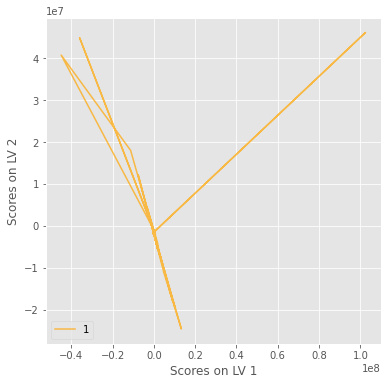

In [ ]:
scores = pd.DataFrame(plsr.x_scores_)
ax = scores.plot(x=0, y=1, color='orange', alpha=0.7, figsize=(6,6))
ax.set_xlabel('Scores on LV 1')
ax.set_ylabel('Scores on LV 2')                                                                  

Text(0, 0.5, 'Scores on LV 2')

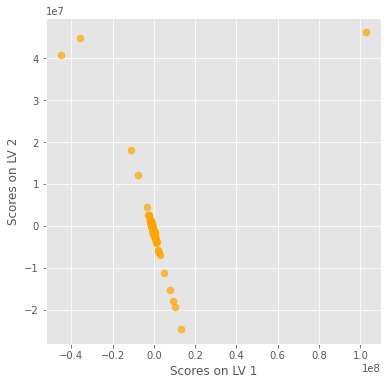

In [ ]:
scores = pd.DataFrame(plsr.x_scores_)
ax = scores.plot(x=0, y=1, kind='scatter', s=50, color='orange',  alpha=0.7, figsize=(6,6))
ax.set_xlabel('Scores on LV 1')
ax.set_ylabel('Scores on LV 2')     